This notebook is downloaded from google colab.

In [1]:
!pip install fireducks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 7.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0


In [2]:
import fireducks.pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt_tab')
nltk.download('stopwords')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


The first thing I do is connect and study the dataset.

In [3]:
df = pd.read_csv('data.csv', sep=',')

In [4]:
df.shape

(159571, 8)

In [5]:
df.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


I noticed extra columns in the table so I'm deleting them. Columns 'id', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate' are not needed because if at least one of them is 1, then 'toxic' is also equal to 1.

In [6]:
df.drop(columns=['id', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [7]:
df['toxic'].value_counts()

toxic
0    144277
1     15294
Name: count, dtype: int64

In [8]:
df_train, df_test = train_test_split(df, test_size=20000)

In [9]:
df_train['toxic'].value_counts()

toxic
0    126224
1     13347
Name: count, dtype: int64

In [10]:
df_test['toxic'].value_counts()

toxic
0    18053
1     1947
Name: count, dtype: int64

First I make a tokenizer step by step, and then I write it as a function.

In [11]:
example = df.iloc[0]['comment_text']
tokens = word_tokenize(example)
tokens_without_punctuation = [x for x in tokens if x not in string.punctuation]
stop_words = stopwords.words()
tokens_without_punctuation_and_stop_words = [x for x in tokens_without_punctuation if x not in stop_words]
snowball = SnowballStemmer(language='english')
stemmed_tokens = [snowball.stem(x) for x in tokens_without_punctuation_and_stop_words]
print(stemmed_tokens)

['explan', 'whi', 'edit', 'made', 'usernam', 'hardcor', 'metallica', 'fan', 'revert', 'they', "n't", 'vandal', 'closur', 'gas', 'i', 'vote', 'new', 'york', 'doll', 'fac', 'and', "n't", 'remov', 'templat', 'talk', 'page', 'i', "'m", 'retir', 'now.89.205.38.27']


In [12]:
snowball = SnowballStemmer(language='english')
stop_words = stopwords.words()

def tokenize(text):
    tokens = word_tokenize(text)
    tokens_without_punctuation = [x for x in tokens if x not in string.punctuation]
    tokens_without_punctuation_and_stop_words = [x for x in tokens_without_punctuation if x not in stop_words]
    stemmed_tokens = [snowball.stem(x) for x in tokens_without_punctuation_and_stop_words]
    return stemmed_tokens

In [14]:
print(tokenize(df.iloc[0]['comment_text']))

['explan', 'whi', 'edit', 'made', 'usernam', 'hardcor', 'metallica', 'fan', 'revert', 'they', "n't", 'vandal', 'closur', 'gas', 'i', 'vote', 'new', 'york', 'doll', 'fac', 'and', "n't", 'remov', 'templat', 'talk', 'page', 'i', "'m", 'retir', 'now.89.205.38.27']


Now I make the model step by step and write it as a pipeline

In [17]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize(x))
features = vectorizer.fit_transform(df_train['comment_text'])

In [18]:
model = LogisticRegression(random_state=0)
model.fit(features, df_train['toxic'])

LogisticRegression(random_state=0)

In [19]:
print(df_train['comment_text'].iloc[0])
model.predict(features[0])

Contested deletion 

This page should not be speedy deleted as an unambiguous copyright infringement, because... (your reason here)   

This is all original work.  Read it please before you automatically place this tag on it.


array([0])

In [34]:
model_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenize)),
    ('model', LogisticRegression(random_state=0))
])

In [35]:
model_pipeline.fit(df_train['comment_text'], df_train['toxic'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x78a5b1e57ce0>)),
                ('model', LogisticRegression(random_state=0))])

In [36]:
print(model_pipeline.predict(['Hi, I love your videos.']))
print(model_pipeline.predict(['I hate you!!!!']))

[0]
[1]


I create precision and recall metrics and build a precision recall curve based on them in order to understand how effective the model is.

In [23]:
prec, rec, thresholds = precision_recall_curve(y_true=df_test['toxic'], y_score=model_pipeline.predict_proba(df_test['comment_text'])[:, 1])

In [24]:
np.where(prec > 0.8)

(array([17995, 17996, 17997, ..., 19802, 19803, 19804]),)

In [25]:
precision_score(y_true=df_test['toxic'], y_pred=model_pipeline.predict_proba(df_test['comment_text'])[:, 1] > thresholds[17995])

0.8003291278113001

In [26]:
recall_score(y_true=df_test['toxic'], y_pred=model_pipeline.predict_proba(df_test['comment_text'])[:, 1] > thresholds[17995])

0.7493579866461222

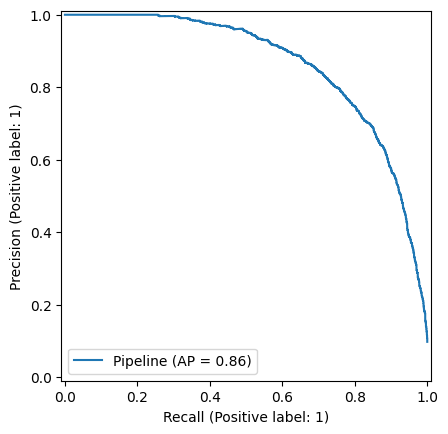

In [27]:
PrecisionRecallDisplay.from_estimator(estimator=model_pipeline, X=df_test['comment_text'], y=df_test['toxic'])

I am satisfied with this result.

At the end I save the model as joblib for further use.

In [28]:
!pip install joblib

In [29]:
import joblib

In [37]:
joblib.dump(model_pipeline, 'model_pipeline.joblib')

['model_pipeline.joblib']